# Case Study - Validation questions

The goal of this notebook is to develop and understand the accuracy of a function to validate the equivalence of two sentences with respect to a question.  This means the function takes as input two strings, and then outputs GPT-3's "Yes" or "No" answer to the question of whether these two sentences say the same thing.

I wanted this function as part of a utils package for developing further cognitive architectures powered by GPT-3.

1. Imports and functions
2. Simple attempt
3. Chain of Thought attempt
4. Temp search with CoT
5. Conclusion

## 1. Imports and functions

In [1]:
import re
import os
import openai
from time import time, sleep
import textwrap
import pandas as pd

In [2]:
def open_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as infile:
        return infile.read()


def save_file(filepath, content):
    with open(filepath, 'w', encoding='utf-8') as outfile:
        outfile.write(content)

# change path to where you store your credentials
openai.api_key = open_file('../../creds/creds.txt')


def gpt3_completion(prompt, label='gpt3', engine='text-davinci-003', temp=0.5, top_p=1.0, tokens=400, freq_pen=2.0, pres_pen=2.0, stop=['asdfasdf', 'asdasdf']):
    max_retry = 5
    retry = 0
    prompt = prompt.encode(encoding='ASCII', errors='ignore').decode()  # force it to fix any unicode errors
    while True:
        try:
            response = openai.Completion.create(
                engine=engine,
                prompt=prompt,
                temperature=temp,
                max_tokens=tokens,
                top_p=top_p,
                frequency_penalty=freq_pen,
                presence_penalty=pres_pen,
                stop=stop)
            text = response['choices'][0]['text'].strip()
            text = re.sub('\s+', ' ', text)
            return text
        except Exception as oops:
            retry += 1
            if retry >= max_retry:
                return "GPT3 error: %s" % oops
            print('Error communicating with OpenAI:', oops)
            sleep(1)


In [3]:
df_questions = pd.read_csv('validation_questions.csv')

## 2. Simple attempt

In [4]:
df_questions

,question_number,question,answer_1,answer_2,validation
0,1,What is the hamburger made of?,The hamburger is made of meat,It's made of meat,Yes
1,2,What is the hamburger made of?,The hamburger is made of meat,It's made of vegetables,No
2,3,Will the stock market go up?,It will go on a bull run,It will go up,Yes
3,4,Will the stock market go up?,It will go on a bull run,It will go sideways,No
4,5,When did she fly the airplane?,She flew the airplane on Tuesday,On Tuesday,Yes
5,6,When did she fly the airplane?,At midday,At midnight,No
6,7,Why is the leaf green?,Because of the Chlorophyll,Chlorophyll makes the plants green,Yes
7,8,Why is the leaf green?,Because of the Chlorophyll,Because of the carbon dioxide,No
8,9,Where are rainbows formed?,Rainbows are formed in the atmosphere,In the sky,Yes
9,10,Where are rainbows formed?,In the sky,In our imagination,No


In [5]:
df_questions['gpt_answer'] = ''

We'll use the following template first:



In the following text we have a question and two answers.  Are the two answers the same? Answer with "Yes" or "No" 

QUESTION:

question_from_dataframe

ANSWERS: 

-first_answer_from_df

-second_answer_from_df

Are they the same answer? YES OR NO:

In [6]:
prompt_beginning = """In the following text we have a question and two answers.  Are the two answers the same? Answer with "Yes" or "No" """            
nl_str = """\n\n"""
question_str = """QUESTION:\n"""
answers_str = """ANSWERS: \n"""
final_answer_str = """Are they the same answer? YES OR NO:"""


Now let's iterate and call GPT-3 to populate the answers

In [7]:
gpt_answer_list = []
for row in df_questions.iterrows():
    question = row[1]['question']
    answer_1 = row[1]['answer_1']
    answer_2 = row[1]['answer_2']
    prompt = prompt_beginning + nl_str + question_str + question + nl_str + answers_str + "-" + answer_1 + "\n" + "-" + answer_2 + nl_str + final_answer_str
    final_answer = gpt3_completion(prompt)
    gpt_answer_list.append(final_answer)

In [8]:
df_questions['gpt_answer'] = gpt_answer_list

Let's see what GPT-3 got wrong

In [9]:
df_questions[df_questions['validation']!=df_questions['gpt_answer']]

,question_number,question,answer_1,answer_2,validation,gpt_answer
8,9,Where are rainbows formed?,Rainbows are formed in the atmosphere,In the sky,Yes,No
16,17,Where are computer chips made?,In China,In a region of China,Yes,No


So we got 18 out of 20 questions right. Just like with 002 version of GPT-3. Let's compare the mistakes vs 002:


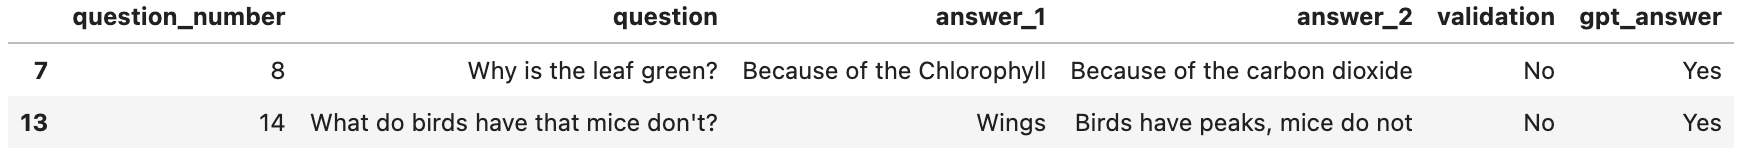

In [15]:
from IPython.display import Image
Image("img/validation_1.png", width= 900)

From my subjective perspective, the 003 mistakes are more "forgivable" due to the ambiguity of the language than the prior mistakes with 002.  Let's keep going with better prompting.

## 3. Chain of Thought attempt

We know that CoT works pretty well (see https://arxiv.org/pdf/2201.11903.pdf)
These papers talk mostly about mathematical reasoning.  Let's give it a shot for this equivalence validator function we are trying to build. To do this we change the final_answer_str.



In the following text we have a question and two answers.  Are the two answers the same? Answer with "Yes" or "No" 

QUESTION:

question_from_dataframe

ANSWERS: 

-first_answer_from_df

-second_answer_from_df

Are they the same answer? Use step by step reasoning and then output only a "Yes" or "No" answer:

In [16]:
final_answer_cot = """Are they the same answer? Use step by step reasoning and then output only a "Yes" or "No" answer:"""


In [ ]:
gpt_cot_list = []
for row in df_questions.iterrows():
        question = row[1]['question']
        answer_1 = row[1]['answer_1']
        answer_2 = row[1]['answer_2']
        prompt = prompt_beginning + nl_str + question_str + question + nl_str + answers_str + "-" + answer_1 + "\n" + "-" + answer_2 + nl_str + final_answer_cot
        #print(prompt)
        final_answer = gpt3_completion(prompt)
        print(final_answer)
        gpt_cot_list.append(final_answer)
        print(row[0])

Let's condense the answers into yes or no

In [18]:
new_cot_list = []
for a in gpt_cot_list:
    if a not in ['Yes','No']:
        prompt_init = """Condense the following sentence into a simple "Yes" or "No" answer"""
        prompt = prompt_init + nl_str + a + nl_str + """ "Yes" or "No" output: """
        final_a = gpt3_completion(prompt)
        final_a.replace('.','').replace(' ','')
        new_cot_list.append(final_a)
    else:
        new_cot_list.append(a)

In [19]:
df_questions['gpt_cot'] = new_cot_list

In [20]:
df_questions

,question_number,question,answer_1,answer_2,validation,gpt_answer,gpt_cot
0,1,What is the hamburger made of?,The hamburger is made of meat,It's made of meat,Yes,Yes,Yes
1,2,What is the hamburger made of?,The hamburger is made of meat,It's made of vegetables,No,No,No
2,3,Will the stock market go up?,It will go on a bull run,It will go up,Yes,Yes,Yes
3,4,Will the stock market go up?,It will go on a bull run,It will go sideways,No,No,No
4,5,When did she fly the airplane?,She flew the airplane on Tuesday,On Tuesday,Yes,Yes,Yes
5,6,When did she fly the airplane?,At midday,At midnight,No,No,No
6,7,Why is the leaf green?,Because of the Chlorophyll,Chlorophyll makes the plants green,Yes,Yes,No
7,8,Why is the leaf green?,Because of the Chlorophyll,Because of the carbon dioxide,No,No,No
8,9,Where are rainbows formed?,Rainbows are formed in the atmosphere,In the sky,Yes,No,Yes
9,10,Where are rainbows formed?,In the sky,In our imagination,No,No,No


This fixed one of those mistakes.  In the 002 case, it fixed both.  It's hard to compare though, since the mistakes were different between the models.

## 4. Temp search with CoT

Let's try out the CoT strategy using different temperatures

In [21]:
temp_list = [0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 1]

In [ ]:
score_list = []
for temp in temp_list:
    gpt_cot_list = []
    print(temp)
    for row in df_questions.iterrows():
        question = row[1]['question']
        answer_1 = row[1]['answer_1']
        answer_2 = row[1]['answer_2']
        prompt = prompt_beginning + nl_str + question_str + question + nl_str + answers_str + "-" + answer_1 + "\n" + "-" + answer_2 + nl_str + final_answer_cot
        #print(prompt)
        final_answer = gpt3_completion(prompt, temp = temp)
        #print(final_answer)
        if final_answer not in ['Yes','No']:
            prompt_init = """Condense the following sentence into a simple "Yes" or "No" answer"""
            prompt = prompt_init + nl_str + a + nl_str + """ "Yes" or "No" output: """
            final_a = gpt3_completion(prompt)
            final_a.replace('.','').replace(' ','')
            final_answer = final_a
        print(row[0])
        gpt_cot_list.append(final_answer)
    col_string = 'CoT_'+str(temp)
    df_questions[col_string] = gpt_cot_list
    score = sum(gpt_cot_list == df_questions['validation'])/20
    score_list.append(score) 


I ran it twice, and got the two accuracy tables below:

In [23]:
df_results = pd.DataFrame(list(zip(temp_list, score_list)), columns =['Temp', 'Score'])

In [24]:
df_results

,Temp,Score
0,0.20,0.85
1,0.40,0.85
2,0.60,0.85
3,0.80,0.90
4,0.90,0.80
5,0.95,0.85
6,1.00,0.80


They are apparently worse than with the 002 model, although as mentioned before, the mistakes are different so it's difficult to compare. Below are the prior results.

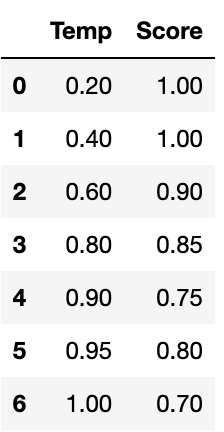

In [27]:
from IPython.display import Image
Image("img/validation_2.png", width= 110)

In [107]:
#df_results = pd.DataFrame(list(zip(temp_list, score_list)), columns =['Temp', 'Score'])

In [108]:
#df_results

So, less temperature is better.. Let's inspect the questions dataframe for the second run:

In [28]:
df_questions

,question_number,question,answer_1,answer_2,validation,gpt_answer,gpt_cot,CoT_0.2,CoT_0.4,CoT_0.6,CoT_0.8,CoT_0.9,CoT_0.95,CoT_1
0,1,What is the hamburger made of?,The hamburger is made of meat,It's made of meat,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
1,2,What is the hamburger made of?,The hamburger is made of meat,It's made of vegetables,No,No,No,No,No,No,No,No,No,No
2,3,Will the stock market go up?,It will go on a bull run,It will go up,Yes,Yes,Yes,No,No,No,Yes,No,No,No
3,4,Will the stock market go up?,It will go on a bull run,It will go sideways,No,No,No,No,No,No,No,No,No,No
4,5,When did she fly the airplane?,She flew the airplane on Tuesday,On Tuesday,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
5,6,When did she fly the airplane?,At midday,At midnight,No,No,No,No,No,No,No,No,No,No
6,7,Why is the leaf green?,Because of the Chlorophyll,Chlorophyll makes the plants green,Yes,Yes,No,No,No,No,No,No,No,No
7,8,Why is the leaf green?,Because of the Chlorophyll,Because of the carbon dioxide,No,No,No,No,No,No,No,No,No,No
8,9,Where are rainbows formed?,Rainbows are formed in the atmosphere,In the sky,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
9,10,Where are rainbows formed?,In the sky,In our imagination,No,No,No,No,No,No,No,No,No,No


## 5. Explicit CoT

In this one, we ask it to be explicit in the output, then call the api again to make it a yes or no answer. So the template will be:

In the following text we have a question and two answers. Are the two answers the same?

QUESTION:

question_from_dataframe

ANSWERS:

-first_answer_from_df

-second_answer_from_df

Are they the same answer? Use step by step reasoning

In [29]:
prompt_beginning = """In the following text we have a question and two answers.  Are the two answers the same? """            
nl_str = """\n\n"""
question_str = """QUESTION:\n"""
answers_str = """ANSWERS: \n"""
final_answer_str = """Are they the same answer? Use step by step reasoning"""


In [ ]:
score_list = []
for temp in temp_list:
    gpt_cot_list = []
    print(temp)
    for row in df_questions.iterrows():
        question = row[1]['question']
        answer_1 = row[1]['answer_1']
        answer_2 = row[1]['answer_2']
        prompt = prompt_beginning + nl_str + question_str + question + nl_str + answers_str + "-" + answer_1 + "\n" + "-" + answer_2 + nl_str + final_answer_cot
        #print(prompt)
        final_answer = gpt3_completion(prompt, temp = temp)
        #print(final_answer)
        if final_answer not in ['Yes','No']:
            prompt_init = """Condense the following sentence into a simple "Yes" or "No" answer"""
            prompt = prompt_init + nl_str + a + nl_str + """ "Yes" or "No" output: """
            final_a = gpt3_completion(prompt)
            final_a.replace('.','').replace(' ','')
            final_answer = final_a
        print(row[0])
        gpt_cot_list.append(final_answer)
        col_string = 'CoT_'+str(temp)
    df_questions[col_string] = gpt_cot_list
    score = sum(gpt_cot_list == df_questions['validation'])/20
    score_list.append(score) 


In [31]:
df_results = pd.DataFrame(list(zip(temp_list, score_list)), columns =['Temp', 'Score'])
df_results

,Temp,Score
0,0.20,0.75
1,0.40,0.70
2,0.60,0.60
3,0.80,0.70
4,0.90,0.80
5,0.95,0.75
6,1.00,0.70


Again, no improvement. Below the prior notebook results with 002 model.

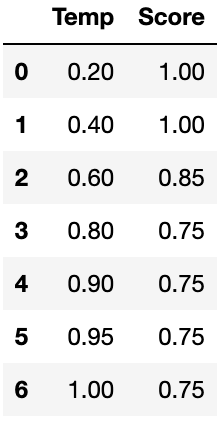

In [32]:
from IPython.display import Image
Image("img/validation_3.png", width= 110)

In [33]:
df_questions

,question_number,question,answer_1,answer_2,validation,gpt_answer,gpt_cot,CoT_0.2,CoT_0.4,CoT_0.6,CoT_0.8,CoT_0.9,CoT_0.95,CoT_1
0,1,What is the hamburger made of?,The hamburger is made of meat,It's made of meat,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
1,2,What is the hamburger made of?,The hamburger is made of meat,It's made of vegetables,No,No,No,No,No,No,No,No,No,No
2,3,Will the stock market go up?,It will go on a bull run,It will go up,Yes,Yes,Yes,No,No,No,No,No,No,No
3,4,Will the stock market go up?,It will go on a bull run,It will go sideways,No,No,No,No,No,No,No,No,No,No
4,5,When did she fly the airplane?,She flew the airplane on Tuesday,On Tuesday,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes
5,6,When did she fly the airplane?,At midday,At midnight,No,No,No,No,No,No,No,No,No,No
6,7,Why is the leaf green?,Because of the Chlorophyll,Chlorophyll makes the plants green,Yes,Yes,No,No,No,No,No,No,No,No
7,8,Why is the leaf green?,Because of the Chlorophyll,Because of the carbon dioxide,No,No,No,No,No,No,No,No,No,No
8,9,Where are rainbows formed?,Rainbows are formed in the atmosphere,In the sky,Yes,No,Yes,No,No,No,No,Yes,No,No
9,10,Where are rainbows formed?,In the sky,In our imagination,No,No,No,No,No,No,No,No,No,No


## 5. Conclusion

The comparison with 002 model here is not good. As can be inspected in the dataframe above, the mistakes are silly, like the clorophyill question, or the market one..